In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model

In [5]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/sp500_fred.xlsx', sheet_name = 'data')
data = data.query('observation_date < 2017 & observation_date > 1959')
# data = data.dropna().reset_index()
column_name = data.columns[-1]
data.head()

,observation_date,SP500
0,2015-10-01,1923.82
1,2015-10-02,1951.36
2,2015-10-05,1987.05
3,2015-10-06,1979.92
4,2015-10-07,1995.83


In [6]:
data.tail()

,observation_date,SP500
322,2016-12-26,NaN
323,2016-12-27,2268.88
324,2016-12-28,2249.92
325,2016-12-29,2249.26
326,2016-12-30,2238.83


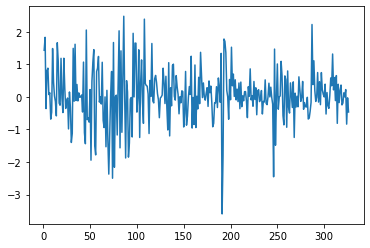

In [7]:
ts = data
ts['target'] = 100* ts[column_name].pct_change(1)
ts['target'].plot()
ts = ts.dropna()

# GARCH(1,1)

In [8]:
garch_fit = arch_model(ts['target']).fit(disp = 'off')
ts['garch'] = garch_fit.conditional_volatility
print(garch_fit)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 target   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -370.572
Distribution:                  Normal   AIC:                           749.144
Method:            Maximum Likelihood   BIC:                           764.154
                                        No. Observations:                  315
Date:                Tue, Oct 20 2020   Df Residuals:                      311
Time:                        14:55:15   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0626  4.080e-02      1.535      0.125 [-1.73

<ipython-input-8-a7ae82b5de36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['garch'] = garch_fit.conditional_volatility


# GJR

In [9]:
gjr_fit = arch_model(ts['target'], p=1, o=1, q=1).fit(disp = 'off')
ts['gjr'] = gjr_fit.conditional_volatility
print(gjr_fit)

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 target   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -368.129
Distribution:                  Normal   AIC:                           746.258
Method:            Maximum Likelihood   BIC:                           765.020
                                        No. Observations:                  315
Date:                Tue, Oct 20 2020   Df Residuals:                      310
Time:                        14:55:17   Df Model:                            5
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0367  3.852e-02      0.952      0.341 [-3.88

<ipython-input-9-f6251a7b5b4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['gjr'] = gjr_fit.conditional_volatility


# GARCH(1,1) with student t

In [10]:
t_garch_fit = arch_model(ts['target'], dist='StudentsT').fit(update_freq=5)
ts['t_garch'] = t_garch_fit.conditional_volatility
print(t_garch_fit)

Iteration:      5,   Func. Count:     38,   Neg. LLF: 512.8468959308773
Iteration:     10,   Func. Count:     70,   Neg. LLF: 359.67680507964974
Optimization terminated successfully    (Exit mode 0)
            Current function value: 359.67680507964974
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 11
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                       target   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -359.677
Distribution:      Standardized Student's t   AIC:                           729.354
Method:                  Maximum Likelihood   BIC:                           748.116
                                              No. Observations:                  315
Date:                      Tue, Oct 20 2020   Df R

<ipython-input-10-8b989174ec1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['t_garch'] = t_garch_fit.conditional_volatility


Text(0.5, 1.0, 'Fitted Volatiltiy')

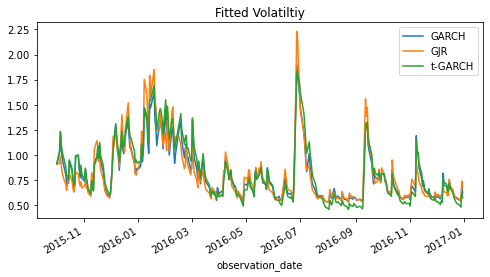

In [25]:
fig, ax = plt.subplots(figsize = (8,4))
ts.set_index('observation_date')[['garch','gjr','t_garch']].plot(ax = ax)

ax.legend(['GARCH','GJR','t-GARCH'])
ax.set_title('Fitted Volatiltiy')

In [12]:
ts.head()

,observation_date,SP500,target,garch,gjr,t_garch
1,2015-10-02,1951.36,1.431527,0.908526,0.911999,0.918543
2,2015-10-05,1987.05,1.828981,1.028621,0.918508,1.039983
3,2015-10-06,1979.92,-0.358823,1.222878,0.991208,1.236533
4,2015-10-07,1995.83,0.803568,1.051993,0.893130,1.104029
5,2015-10-08,2013.43,0.881839,0.968533,0.825005,1.036000


# Analysis of models

# PITS

In [13]:
garch_pits = []
gjr_pits = []
t_garch_pits = []

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]


for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    garch_pits.append( scipy.stats.norm.cdf(actual, loc=garch_mean, scale=garch_vol))
    gjr_pits.append(scipy.stats.norm.cdf(actual, loc=gjr_mean, scale=gjr_vol))
    t_garch_pits.append( scipy.stats.t.cdf(actual, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol) )

    
print(stats.kstest(garch_pits, 'uniform'))
print(stats.kstest(gjr_pits, 'uniform'))
print(stats.kstest(t_garch_pits, 'uniform'))

KstestResult(statistic=0.05558601108169137, pvalue=0.27443455883141255)
KstestResult(statistic=0.059017875298010725, pvalue=0.2139648065705847)
KstestResult(statistic=0.056956394388302994, pvalue=0.2489432322083146)


# KL Divergence

In [14]:
garch_kl = 0
gjr_kl = 0
t_garch_kl = 0

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]


for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    garch_kl = garch_kl + scipy.stats.norm.logpdf(actual, loc=garch_mean, scale=garch_vol)
    gjr_kl = gjr_kl + scipy.stats.norm.logpdf(actual, loc=gjr_mean, scale=gjr_vol)
    t_garch_kl =  t_garch_kl + scipy.stats.t.logpdf(actual, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol)

    
print(garch_kl)
print(gjr_kl)
print(t_garch_kl)

-370.5721036402501
-368.12881459572236
-369.18351508797673


# Conditional Coverage

In [15]:
coverage_df = pd.DataFrame(columns = ['prob','garch', 'gjr','t_garch']).set_index('prob')
prob_list = np.linspace(.01,.99,21)

for prob in prob_list:
    coverage_df.loc[prob] = 0.0

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]

for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    for prob in prob_list:        
        garch_ci = scipy.stats.norm.interval(prob, loc= garch_mean, scale= garch_vol)
        gjr_ci = scipy.stats.norm.interval(prob, loc= gjr_mean, scale= gjr_vol)
        t_garch_ci = scipy.stats.t.interval(prob, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol)
        
        coverage_df.loc[prob] = coverage_df.loc[prob] + [1*(actual > garch_ci[0])*(actual < garch_ci[1]),
                                                         1*(actual > gjr_ci[0])*(actual < gjr_ci[1]),
                                                         1*(actual > t_garch_ci[0])*(actual < t_garch_ci[1])]
                                                                
coverage_df = coverage_df.div(len(ts))
coverage_df['theoretical'] = prob_list

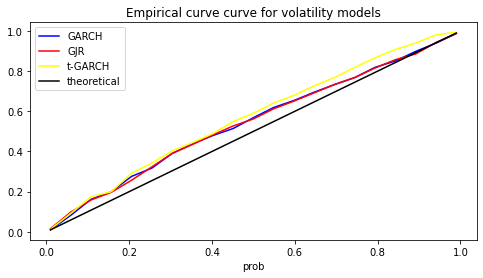

In [28]:
fig, ax = plt.subplots(figsize = (8,4))
coverage_df.plot(color = ['Blue','Red','Yellow','Black'], ax = ax)

ax.set_title('Empirical curve curve for volatility models')
ax.legend(['GARCH','GJR','t-GARCH','theoretical'])

In [17]:
coverage_df

,garch,gjr,t_garch,theoretical
prob,,,,
0.010,0.009524,0.015873,0.012698,0.010
0.059,0.082540,0.098413,0.092063,0.059
0.108,0.161905,0.158730,0.174603,0.108
0.157,0.200000,0.196825,0.200000,0.157
0.206,0.276190,0.257143,0.292063,0.206
0.255,0.317460,0.323810,0.342857,0.255
0.304,0.390476,0.390476,0.403175,0.304
0.353,0.438095,0.434921,0.444444,0.353
0.402,0.479365,0.482540,0.488889,0.402


# Interval score functions

In [18]:
def score(x,lower,upper,prob):
    return (upper-lower) + (2/(1-prob))*(max(x-upper,0) + max(lower-x,0))

In [19]:
score_df = pd.DataFrame(columns = ['prob','garch', 'gjr','t_garch']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    score_df.loc[prob] = 0.0

garch_mean = garch_fit.params[0]    
gjr_mean = gjr_fit.params[0]
t_garch_mean = t_garch_fit.params[0]    
t_garch_dist = t_garch_fit.params[4]

for time in ts.index:
    actual = ts.loc[time,'target']
    
    garch_vol =  ts.loc[time,'garch']
    gjr_vol = ts.loc[time,'gjr']
    t_garch_vol = ts.loc[time,'t_garch']

    for prob in prob_list:        
        garch_ci = scipy.stats.norm.interval(prob, loc= garch_mean, scale= garch_vol)
        gjr_ci = scipy.stats.norm.interval(prob, loc= gjr_mean, scale= gjr_vol)
        t_garch_ci = scipy.stats.t.interval(prob, t_garch_dist, loc=t_garch_mean, scale=t_garch_vol)
        
        score_df.loc[prob] = score_df.loc[prob] + [score(actual, garch_ci[0],garch_ci[1], prob),
                                                   score(actual, gjr_ci[0],gjr_ci[1], prob),
                                                   score(actual, t_garch_ci[0],t_garch_ci[1], prob) ]
                                                                
score_df = score_df.div(len(ts))

Text(0.5, 1.0, 'Interval forecast scores')

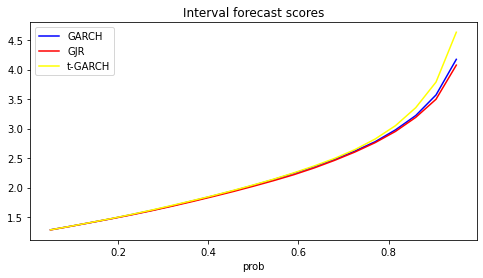

In [29]:
fig, ax = plt.subplots(figsize = (8,4))
score_df.plot(color = ['Blue','Red','Yellow'], ax = ax)

ax.legend(['GARCH', 'GJR','t-GARCH'])
ax.set_title('Interval forecast scores')

In [21]:
score_df

,garch,gjr,t_garch
prob,,,
0.050,1.286197,1.283991,1.285353
0.095,1.346510,1.345478,1.347029
0.140,1.410030,1.408851,1.411271
0.185,1.474764,1.473057,1.476720
0.230,1.543994,1.539578,1.547388
0.275,1.616072,1.610250,1.621097
0.320,1.693588,1.686136,1.700350
0.365,1.775755,1.765431,1.780970
0.410,1.859549,1.848295,1.864403
